## Computer Vision Image Classification - by Putri Anggia Cahyani
### Prediksi bunga Daisy dan bunga Matahari

Pada case ini, saya membuat sebuah klasifikasi gambar dalam penerapan bidang computer vision menggunakan konfigurasi Tensorflow. Dalam pelatihan model, saya menggunakan arsitektur CNN dengan Adam optimizer dan binary cross-entropy sebagai fungsi lossnya.

### Hasil :
- Accuracy : 0.8294
- Loss : 0.3670
- ROC area : 0.96

### Membangun Datasets yang akan digunakan

In [ ]:
#Import Library OS/Zipfile
import os
import zipfile

base_url = "/content/drive/MyDrive/flower_datasets"

train_zip = base_url + "/Training.zip"
zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall('/tmp')

val_zip = base_url + "/Validation.zip"
zip_ref = zipfile.ZipFile(val_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# Folder training untuk class daisy
train_daisy_dir = os.path.join('/tmp/Training/daisy')

# Folder training untuk class sunflower
train_sunflower_dir = os.path.join('/tmp/Training/sunflower')

# Folder validation untuk class daisy
valid_daisy_dir = os.path.join('/tmp/Validation/daisy')

# Folder validation untuk class sunflower
valid_sunflower_dir = os.path.join('/tmp/Validation/sunflower')

In [ ]:
train_daisy_names = os.listdir(train_daisy_dir)
print(train_daisy_names[:10])

train_sunflower_names = os.listdir(train_sunflower_dir)
print(train_sunflower_names[:10])

validation_daisy_names = os.listdir(valid_daisy_dir)
print(validation_daisy_names[:10])

validation_sunflower_names = os.listdir(valid_sunflower_dir)
print(validation_sunflower_names[:10])

['2514748602_343d4727c0_n.jpg', '3196066025_d187108070_n.jpg', '2346726545_2ebce2b2a6.jpg', '2877860110_a842f8b14a_m.jpg', '2479956481_8d1a9699be_n.jpg', '3450822975_7e77d67636_n.jpg', '2408024540_37f0be7cc0_n.jpg', '2511306240_9047015f2d_n.jpg', '2713919471_301fcc941f.jpg', '2578695910_5ab8ee17c1_n.jpg']
['215798352_184d8040d1.jpg', '200288046_0032f322ff_n.jpg', '193874852_fb633d8d00_n.jpg', '35477171_13cb52115c_n.jpg', '22203670478_9ec5c2700b_n.jpg', '21518663809_3d69f5b995_n.jpg', '310380634_60e6c79989.jpg', '1022552036_67d33d5bd8_n.jpg', '1240625276_fb3bd0c7b1.jpg', '821368661_4ab4343f5a.jpg']
['4683997791_56e7d3c03c_n.jpg', '3703643767_dee82cdef9_n.jpg', '4276898893_609d11db8b.jpg', '520752848_4b87fb91a4.jpg', '4785888250_b661eac225_n.jpg', '3758221664_b19116d61f.jpg', '4669117051_ce61e91b76.jpg', '105806915_a9c13e2106_n.jpg', '4065883015_4bb6010cb7_n.jpg', '521762040_f26f2e08dd.jpg']
['16153267338_2f39906bcb_n.jpg', '3920137864_e922ab25b4_n.jpg', '2883115621_4837267ea1_m.jpg', '2

In [ ]:
print('total training Daisy images:', len(os.listdir(train_daisy_dir)))
print('total training Sunflower images:', len(os.listdir(train_sunflower_dir)))
print('total validation Daisy images:', len(os.listdir(valid_daisy_dir)))
print('total validation Sunflower images:', len(os.listdir(valid_sunflower_dir)))

total training Daisy images: 130
total training Sunflower images: 130
total validation Daisy images: 170
total validation Sunflower images: 170


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2 as cv

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 1

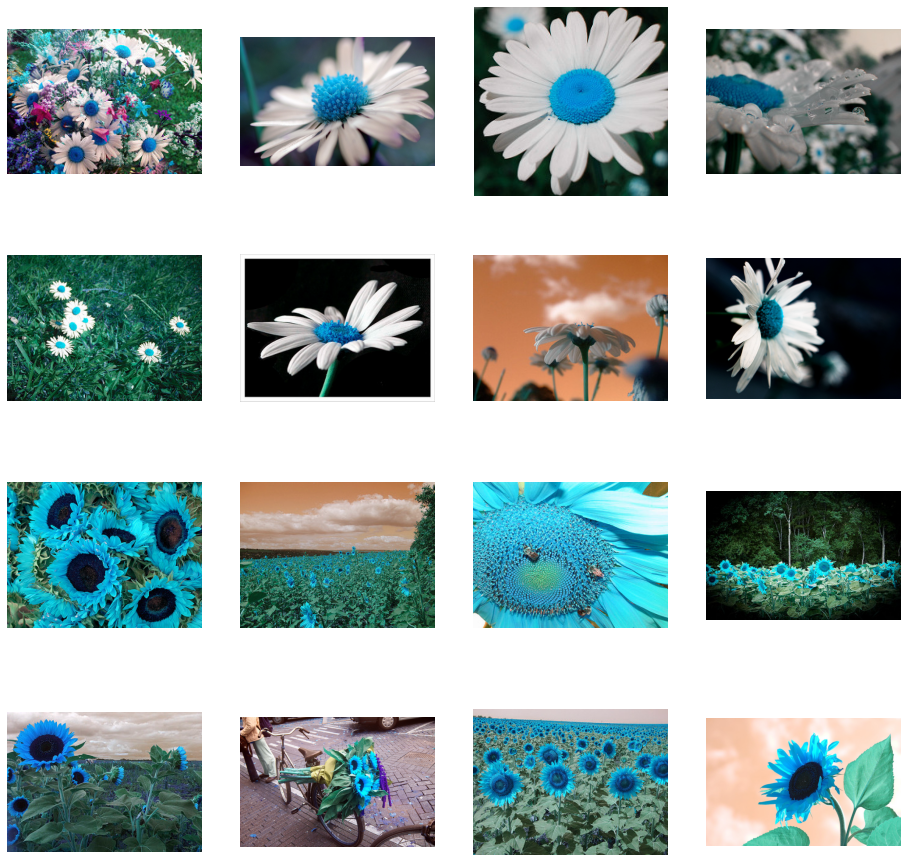

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_daisy_pic = [os.path.join(train_daisy_dir, fname)
                for fname in train_daisy_names[pic_index-8:pic_index]]
next_sunflower_pic = [os.path.join(train_sunflower_dir, fname)
                for fname in train_sunflower_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_daisy_pic + next_sunflower_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  im = cv.imread(img_path)
  plt.imshow(im)

plt.show()


### Data Pre-Processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(
        '/tmp/Training/',
        classes = ['daisy', 'sunflower'],
        target_size=(200, 200),
        batch_size=120,
        class_mode='binary')


validation_generator = validation_datagen.flow_from_directory(
        '/tmp/Validation/',
        classes = ['daisy', 'sunflower'],
        target_size=(200, 200),
        batch_size=19,
        class_mode='binary',
        shuffle=False)

Found 260 images belonging to 2 classes.
Found 340 images belonging to 2 classes.


(120, 200, 200, 3)


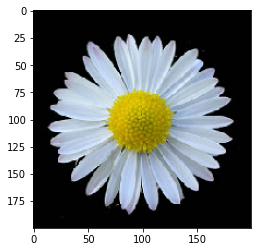

(120, 200, 200, 3)


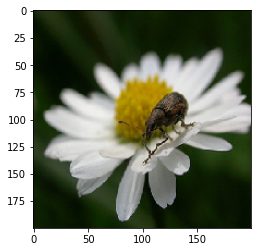

(20, 200, 200, 3)


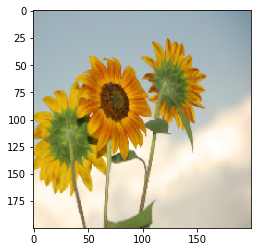

(120, 200, 200, 3)


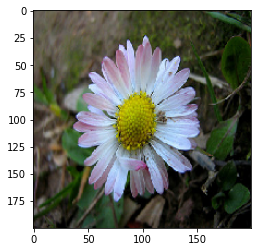

(120, 200, 200, 3)


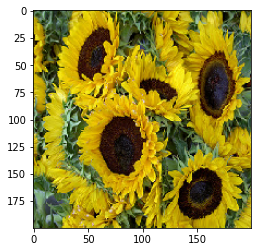

In [ ]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Membuat Model

In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
'''#Make yang asli dari notebook
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           input_shape = (200, 200, 3),
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),

                                    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),

                                    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])'''

In [ ]:
#Make maxpool2D
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3, 3),activation='relu',input_shape = (200, 200, 3)),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(32, (3, 3),activation='relu'),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(64, (3, 3),activation='relu'),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(64, (3, 3),activation='relu'),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Conv2D(64, (3, 3),activation='relu'),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

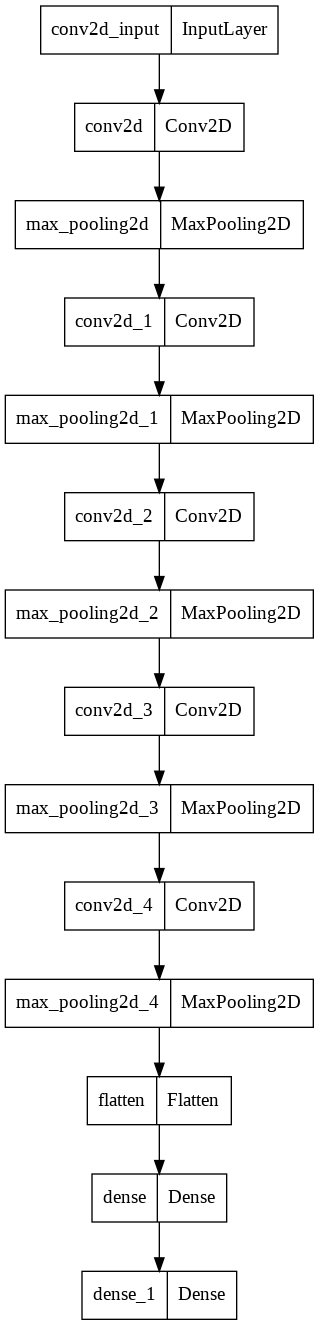

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### Melatih model

In [ ]:
history = model.fit(train_generator,
      steps_per_epoch=3,
      epochs=5,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=3)

Epoch 1/5
3/3 [==============================] - 9s 2s/step - loss: 0.7008 - accuracy: 0.5077 - val_loss: 0.6522 - val_accuracy: 1.0000
Epoch 2/5
3/3 [==============================] - 8s 2s/step - loss: 0.6678 - accuracy: 0.6500 - val_loss: 0.7811 - val_accuracy: 0.1053
Epoch 3/5
3/3 [==============================] - 8s 2s/step - loss: 0.5713 - accuracy: 0.6269 - val_loss: 0.5430 - val_accuracy: 0.8421
Epoch 4/5
3/3 [==============================] - 8s 2s/step - loss: 0.4119 - accuracy: 0.8462 - val_loss: 0.8656 - val_accuracy: 0.6842
Epoch 5/5
3/3 [==============================] - 8s 2s/step - loss: 0.3804 - accuracy: 0.8423 - val_loss: 0.0861 - val_accuracy: 0.9474


### Accuracy, ROC Curve, and AUC

In [ ]:
model.evaluate(validation_generator)

18/18 [==============================] - 3s 183ms/step - loss: 0.3670 - accuracy: 0.8294


[0.36701253056526184, 0.8294117450714111]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

18/18 [==============================] - 3s 181ms/step


In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

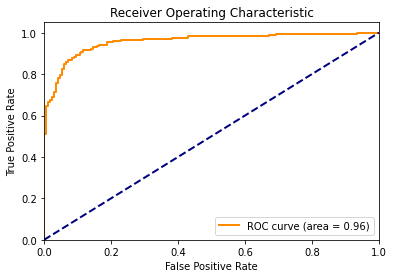

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Saving 12193032636_b50ae7db35_n.jpg to 12193032636_b50ae7db35_n.jpg
[0.]
12193032636_b50ae7db35_n.jpg ini adalah Bunga Daisy


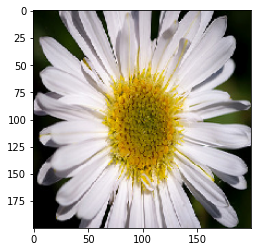

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " ini adalah Bunga Daisy")
  else:
    print(fn + " ini adalah Bunga Matahari")


In [ ]:
#import os,signal
#os.kill(os.getpid(), signal.SIGKILL)